In [1]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime
import statistics
from functools import reduce
from scipy import stats

In [2]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"

count = 0
# import data
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [3]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

# 2016-2019 data
df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 5000)& (df1['usd_pledged'] > 100)]

df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')


/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


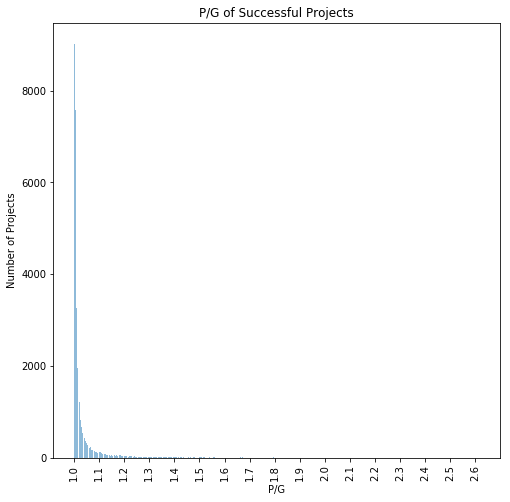

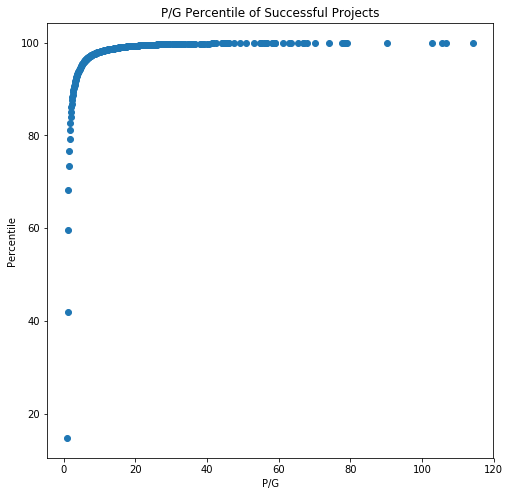

In [90]:
df1_success['P/G'] = df1_success['usd_pledged'] / df1_success['goal']

df2_pg_success = df1_success.copy()

# dictionary for all_projects
new_dict = {}

for j in df2_pg_success['P/G']:
    curr_key = round(j, 1)
    if curr_key in new_dict.keys():
        new_dict[curr_key] += 1
    else:
        new_dict[curr_key] = 1
        
new_dict = collections.OrderedDict(sorted(new_dict.items()))
fig1 = plt.figure(figsize = (8,8))
objects = tuple(new_dict.keys())
y_pos = np.arange(len(objects))
performance = new_dict.values()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
locs, labs = plt.xticks() 
plt.xticks(locs[0::20], rotation = 'vertical')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
plt.title('P/G of Successful Projects')
plt.show()
        
lst = []
for k,v in new_dict.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
dict_distr = collections.OrderedDict(sorted(dict_distr.items()))
#print(dict_distr)
    
fig2 = plt.figure(figsize = (8,8))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('P/G')
plt.ylabel('Percentile')
plt.title('P/G Percentile of Successful Projects')
plt.show()

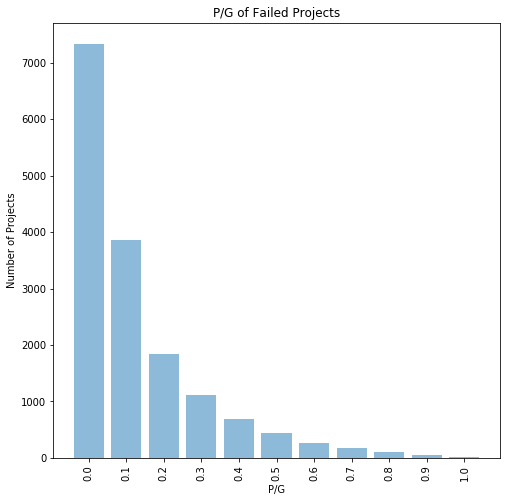

OrderedDict([(0.0, 23.097997228870135), (0.1, 58.35117773019272), (0.2, 76.31313767477012), (0.3, 85.62476382415922), (0.4, 91.30558004786496), (0.5, 94.89230381660158), (0.6, 97.12180375362136), (0.7, 98.46958055170677), (0.8, 99.31351555611538), (0.9, 99.77012218163496), (1.0, 99.95906285426376)])


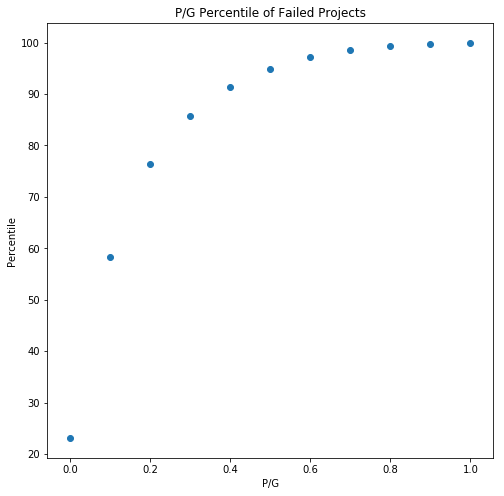

In [85]:
df1_fail['P/G'] = df1_fail['usd_pledged'] / df1_fail['goal']

df2_pg_fail = df1_fail.copy()

# dictionary for all_projects
new_dict = {}

for j in df2_pg_fail['P/G']:
    curr_key = round(j, 1)
    if curr_key in new_dict.keys():
        new_dict[curr_key] += 1
    else:
        new_dict[curr_key] = 1

        
new_dict = collections.OrderedDict(sorted(new_dict.items()))
fig1 = plt.figure(figsize = (8,8))
objects = tuple(new_dict.keys())
y_pos = np.arange(len(objects))
performance = new_dict.values()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
plt.title('P/G of Failed Projects')
plt.show()
        
lst = []
for k,v in new_dict.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
dict_distr = collections.OrderedDict(sorted(dict_distr.items()))
print(dict_distr)
    
fig2 = plt.figure(figsize = (8,8))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('P/G')
plt.ylabel('Percentile')
plt.title('P/G Percentile of Failed Projects')
plt.show()

In [81]:
print(new_dict.values())

odict_values([7334, 3861, 1843, 1114, 690, 449, 259, 169, 99, 46, 14])


Text(0.5, 1.0, 'Median Goal Size vs. Duration')

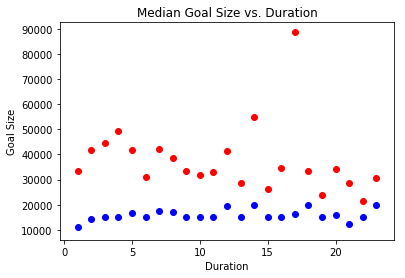

In [91]:
### DURATION VS GOAL SIZE

df2 = df1.copy()

df2['duration'] = (df2['deadline'] - df2['created_at']) / np.timedelta64(1,'M')

num_months = 25
count = 0

# dictionary for all_projects
new_dict_dg = {}
new_dict_dp = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg[i] = []
    new_dict_dp[i] = 0
for j in df2['duration']:
    temp = df2.loc[df2['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['goal'])
        new_dict_dg[round(j)].append(temp_val[0])
        new_dict_dp[round(j)] += 1
        
avg_dict_dg = {}
med_dict_dg = {}
for k,v in new_dict_dg.items():
    if v != [] and k > 0:
        avg_dict_dg[k] = sum(v) / len(v)
        med_dict_dg[k] = statistics.median(v)

plt.scatter(avg_dict_dg.keys(),avg_dict_dg.values(), color = 'red')
plt.xlabel('Goal Size')
plt.ylabel('Duration')
plt.title('Mean Goal Size vs. Duration')

plt.scatter(med_dict_dg.keys(), med_dict_dg.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('Goal Size')
plt.title('Median Goal Size vs. Duration')

Text(0.5, 1.0, 'Mean vs. Median Goal Size vs. Duration for Successful Projects')

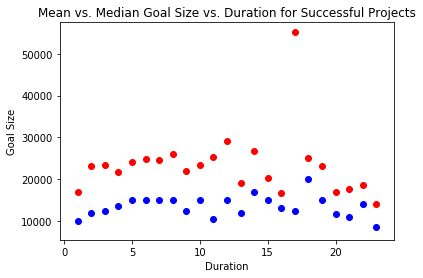

In [95]:
### DURATION VS GOAL SIZE

df2_success = df1_success.copy()

df2_success['duration'] = (df2_success['deadline'] - df2_success['created_at']) / np.timedelta64(1,'M')

num_months = 25

# dictionary for all_projects
new_dict_dg_success = {}
new_dict_dp_success = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg_success[i] = []
    new_dict_dp_success[i] = 0
for j in df2_success['duration']:
    temp = df2_success.loc[df2_success['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['goal'])
        new_dict_dg_success[round(j)].append(temp_val[0])
        new_dict_dp_success[round(j)] += 1
        
avg_dict_dg_success = {}
med_dict_dg_success = {}
for k,v in new_dict_dg_success.items():
    if v != [] and k > 0:
        avg_dict_dg_success[k] = sum(v) / len(v)
        med_dict_dg_success[k] = statistics.median(v)

plt.scatter(avg_dict_dg_success.keys(),avg_dict_dg_success.values(), color = 'red')
plt.scatter(med_dict_dg_success.keys(), med_dict_dg_success.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('Goal Size')
plt.title('Mean vs. Median Goal Size vs. Duration for Successful Projects')

Text(0.5, 1.0, 'Mean vs. Median Goal Size vs. Duration for Failed Projects')

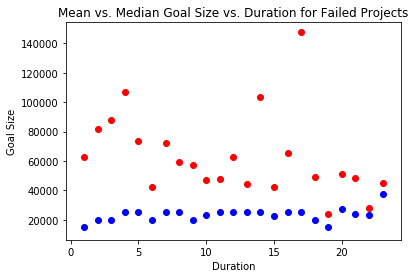

In [99]:
### DURATION VS GOAL SIZE

df2_fail = df1_fail.copy()

df2_fail['duration'] = (df2_fail['deadline'] - df2_fail['created_at']) / np.timedelta64(1,'M')

num_months = 25

new_dict_dg_fail = {}
new_dict_dp_fail = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg_fail[i] = []
    new_dict_dp_fail[i] = 0
for j in df2_fail['duration']:
    temp = df2_fail.loc[df2_fail['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['goal'])
        new_dict_dg_fail[round(j)].append(temp_val[0])
        new_dict_dp_fail[round(j)] += 1
        
avg_dict_dg_fail = {}
med_dict_dg_fail = {}
for k,v in new_dict_dg_fail.items():
    if v != [] and k > 0:
        avg_dict_dg_fail[k] = sum(v) / len(v)
        med_dict_dg_fail[k] = statistics.median(v)

plt.scatter(avg_dict_dg_fail.keys(),avg_dict_dg_fail.values(), color = 'red')
plt.scatter(med_dict_dg_fail.keys(), med_dict_dg_fail.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('Goal Size')
plt.title('Mean vs. Median Goal Size vs. Duration for Failed Projects')

Text(0.5, 1.0, 'Mean vs. Median Pledged Size vs. Duration for Successful Projects')

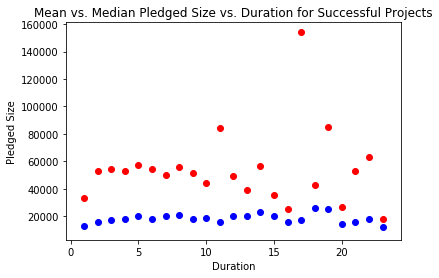

In [96]:
### DURATION VS GOAL SIZE

df2_success = df1_success.copy()

df2_success['duration'] = (df2_success['deadline'] - df2_success['created_at']) / np.timedelta64(1,'M')

num_months = 25

# dictionary for all_projects
new_dict_dg_success = {}
new_dict_dp_success = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg_success[i] = []
    new_dict_dp_success[i] = 0
for j in df2_success['duration']:
    temp = df2_success.loc[df2_success['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['usd_pledged'])
        new_dict_dg_success[round(j)].append(temp_val[0])
        new_dict_dp_success[round(j)] += 1
        
avg_dict_dg_success = {}
med_dict_dg_success = {}
for k,v in new_dict_dg_success.items():
    if v != [] and k > 0:
        avg_dict_dg_success[k] = sum(v) / len(v)
        med_dict_dg_success[k] = statistics.median(v)

plt.scatter(avg_dict_dg_success.keys(),avg_dict_dg_success.values(), color = 'red')
plt.scatter(med_dict_dg_success.keys(), med_dict_dg_success.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('Pledged Size')
plt.title('Mean vs. Median Pledged Size vs. Duration for Successful Projects')

Text(0.5, 1.0, 'Mean vs. Median Pledged Size vs. Duration for Failed Projects')

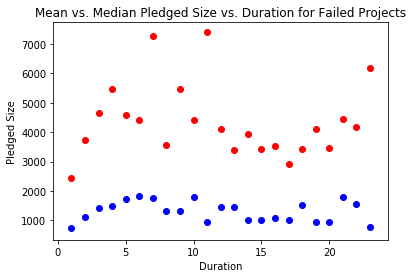

In [100]:
### DURATION VS GOAL SIZE

df2_fail = df1_fail.copy()

df2_fail['duration'] = (df2_fail['deadline'] - df2_fail['created_at']) / np.timedelta64(1,'M')

num_months = 25

# dictionary for all_projects
new_dict_dg_fail = {}
new_dict_dp_fail = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg_fail[i] = []
    new_dict_dp_fail[i] = 0
for j in df2_fail['duration']:
    temp = df2_fail.loc[df2_fail['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['usd_pledged'])
        new_dict_dg_fail[round(j)].append(temp_val[0])
        new_dict_dp_fail[round(j)] += 1
        
avg_dict_dg_fail = {}
med_dict_dg_fail = {}
for k,v in new_dict_dg_fail.items():
    if v != [] and k > 0:
        avg_dict_dg_fail[k] = sum(v) / len(v)
        med_dict_dg_fail[k] = statistics.median(v)

plt.scatter(avg_dict_dg_fail.keys(),avg_dict_dg_fail.values(), color = 'red')
plt.scatter(med_dict_dg_fail.keys(), med_dict_dg_fail.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('Pledged Size')
plt.title('Mean vs. Median Pledged Size vs. Duration for Failed Projects')

Text(0.5, 1.0, 'Mean vs. Median P/G vs. Duration')

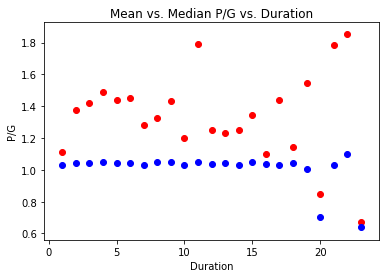

In [94]:
### DURATION VS P/G SIZE

df2 = df1.copy()

df2['duration'] = (df2['deadline'] - df2['created_at']) / np.timedelta64(1,'M')

num_months = 25

# dictionary for all_projects
new_dict_dg = {}
new_dict_dp = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg[i] = []
    new_dict_dp[i] = 0
for j in df2['duration']:
    temp = df2.loc[df2['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['usd_pledged'])[0] / list(temp['goal'])[0]
        new_dict_dg[round(j)].append(temp_val)
        new_dict_dp[round(j)] += 1
        
avg_dict_dg = {}
med_dict_dg = {}
for k,v in new_dict_dg.items():
    if v != [] and k > 0:
        avg_dict_dg[k] = sum(v) / len(v)
        med_dict_dg[k] = statistics.median(v)

plt.scatter(avg_dict_dg.keys(),avg_dict_dg.values(), color = 'red')
plt.scatter(med_dict_dg.keys(), med_dict_dg.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('P/G')
plt.title('Mean vs. Median P/G vs. Duration')

Text(0.5, 1.0, 'Mean vs. Median P/G vs. Duration for Successful Projects')

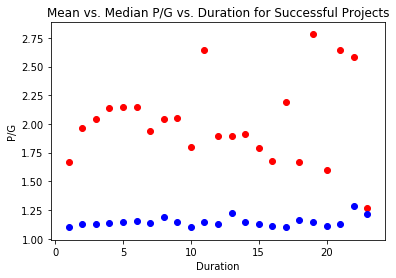

In [101]:
### DURATION VS P/G SIZE

df2_success = df1_success.copy()

df2_success['duration'] = (df2_success['deadline'] - df2_success['created_at']) / np.timedelta64(1,'M')

num_months = 25

# dictionary for all_projects
new_dict_dg_success = {}
new_dict_dp_success = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg_success[i] = []
    new_dict_dp_success[i] = 0
for j in df2_success['duration']:
    temp = df2_success.loc[df2_success['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['usd_pledged'])[0] / list(temp['goal'])[0]
        new_dict_dg_success[round(j)].append(temp_val)
        new_dict_dp_success[round(j)] += 1
        
avg_dict_dg_success = {}
med_dict_dg_success = {}
for k,v in new_dict_dg_success.items():
    if v != [] and k > 0:
        avg_dict_dg_success[k] = sum(v) / len(v)
        med_dict_dg_success[k] = statistics.median(v)

plt.scatter(avg_dict_dg_success.keys(),avg_dict_dg_success.values(), color = 'red')
plt.scatter(med_dict_dg_success.keys(), med_dict_dg_success.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('P/G')
plt.title('Mean vs. Median P/G vs. Duration for Successful Projects')

Text(0.5, 1.0, 'Mean vs. Median P/G vs. Duration for Failed Projects')

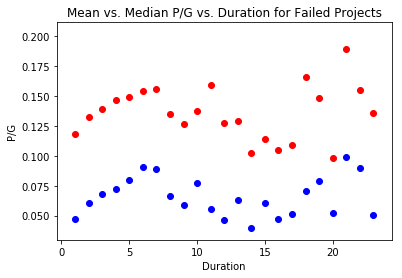

In [97]:
### DURATION VS P/G SIZE

df2_fail= df1_fail.copy()

df2_fail['duration'] = (df2_fail['deadline'] - df2_fail['created_at']) / np.timedelta64(1,'M')

num_months = 25

# dictionary for all_projects
new_dict_dg_fail = {}
new_dict_dp_fail = {}
for i in range(num_months): # set up blank dictionary
    new_dict_dg_fail[i] = []
    new_dict_dp_fail[i] = 0
for j in df2_fail['duration']:
    temp = df2_fail.loc[df2_fail['duration'] == j]
    if round(j) < num_months - 1: # round duration into number of months
        temp_val = list(temp['usd_pledged'])[0] / list(temp['goal'])[0]
        new_dict_dg_fail[round(j)].append(temp_val)
        new_dict_dp_fail[round(j)] += 1
        
avg_dict_dg_fail = {}
med_dict_dg_fail = {}
for k,v in new_dict_dg_fail.items():
    if v != [] and k > 0:
        avg_dict_dg_fail[k] = sum(v) / len(v)
        med_dict_dg_fail[k] = statistics.median(v)

plt.scatter(avg_dict_dg_fail.keys(),avg_dict_dg_fail.values(), color = 'red')
plt.scatter(med_dict_dg_fail.keys(), med_dict_dg_fail.values(), color = 'blue')
plt.xlabel('Duration')
plt.ylabel('P/G')
plt.title('Mean vs. Median P/G vs. Duration for Failed Projects')

Text(0.5, 1.0, 'Probability of Success vs. Duration')

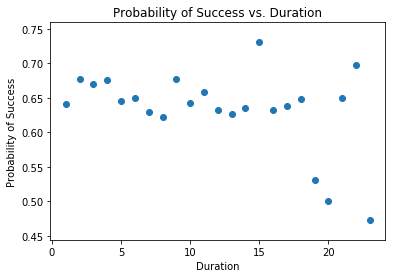

In [102]:
# dictionary for probability of success
new_dict_dp_success_rate = {}

for i in avg_dict_dg_success.keys():
    if new_dict_dp[i] > 0: # sufficient number of projects with that duration
        new_dict_dp_success_rate[i] = new_dict_dp_success[i] / new_dict_dp[i]
        
plt.scatter(new_dict_dp_success_rate.keys(), new_dict_dp_success_rate.values())
plt.xlabel('Duration')
plt.ylabel('Probability of Success')
plt.title('Probability of Success vs. Duration')

OrderedDict([(5000, 0.3109934573002755), (6000, 5.674285468319559), (7000, 12.887396694214877), (8000, 19.903581267217632), (9000, 25.761880165289256), (10000, 34.66769972451791), (11000, 43.162448347107436), (12000, 46.133565771349865), (13000, 48.92174586776859), (14000, 49.88916150137741), (15000, 54.6154011707989), (16000, 59.363162878787875), (17000, 60.238033746556475), (18000, 61.383006198347104), (19000, 62.37840048209367), (20000, 65.99302685950413), (21000, 69.58935950413223), (22000, 70.04455061983471), (23000, 70.49328512396694), (24000, 70.80535468319559), (25000, 73.62797004132231), (26000, 76.40861742424242), (27000, 76.68948002754821), (28000, 77.04459366391184), (29000, 77.335141184573), (30000, 79.28719008264463), (31000, 81.20587982093664), (32000, 81.36299070247934), (33000, 81.60511363636364), (34000, 81.78267045454545), (35000, 82.66722623966942), (36000, 83.57760847107438), (37000, 83.72180612947659), (38000, 83.88860192837465), (39000, 84.05001721763085), (40000

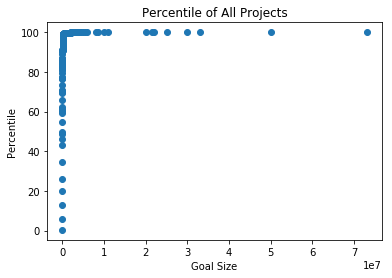

In [41]:
df2 = df1.copy()

max_goal = round(max(df2['goal']) / 1000.0) * 1000.0

# dictionary for all_projects
new_dict = {}

for j in df2['goal']:
    curr_key = int(round(j / 1000.0) * 1000.0)
    if curr_key in new_dict.keys():
        new_dict[curr_key] += 1
    else:
        new_dict[curr_key] = 1
        
lst = []
for k,v in new_dict.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(collections.OrderedDict(sorted(dict_distr.items())))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('Goal Size')
plt.ylabel('Percentile')
plt.title('Percentile of All Projects')
plt.show()

OrderedDict([(5000, 0.3678153403517949), (6000, 6.7007781337867), (7000, 15.124566795265808), (8000, 23.22958216177336), (9000, 29.966324462172235), (10000, 39.6521284247695), (11000, 48.89491924409861), (12000, 52.1513110573465), (13000, 55.21643889361145), (14000, 56.285555482900676), (15000, 61.258418884456944), (16000, 66.2083959981691), (17000, 67.10259595893547), (18000, 68.28287451775321), (19000, 69.3013143268162), (20000, 72.86176682142157), (21000, 76.40423723272086), (22000, 76.85051984568103), (23000, 77.28535931471916), (24000, 77.57307264761656), (25000, 80.1428758255411), (26000, 82.66690642777742), (27000, 82.92355979860066), (28000, 83.24560256326424), (29000, 83.49898646439547), (30000, 85.31517687831034), (31000, 87.10030733015105), (32000, 87.24416399659975), (33000, 87.46975740534886), (34000, 87.61851827633558), (35000, 88.3410710782711), (36000, 89.08487543320473), (37000, 89.19767213757929), (38000, 89.3251814555679), (39000, 89.43961289478847), (40000, 90.15562

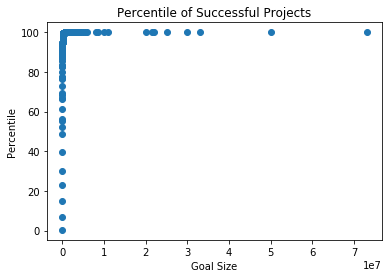

In [42]:
# dictionary for successful projects

df2_success = df1_success.copy()
new_dict_success = {}

for j in df2_success['goal']:
    curr_key = int(round(j / 1000.0) * 1000.0)
    if curr_key in new_dict_success.keys():
        new_dict_success[curr_key] += 1
    else:
        new_dict_success[curr_key] = 1
        
lst_success = []
for k,v in new_dict_success.items():
    temp_lst = [k]*v
    lst_success.append(temp_lst)
    
lst = []
for k,v in new_dict_success.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(collections.OrderedDict(sorted(dict_distr.items())))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('Goal Size')
plt.ylabel('Percentile')
plt.title('Percentile of Successful Projects')
plt.show()

OrderedDict([(5000, 0.2046857286811941), (6000, 3.7000881723138934), (7000, 8.581055548557753), (8000, 13.49981105932737), (9000, 17.66595289079229), (10000, 25.069278246630557), (11000, 32.123063358105554), (12000, 34.544652978964606), (13000, 36.79934500566822), (14000, 37.5708527522358), (15000, 41.82201788638368), (16000, 46.18024940168787), (17000, 47.017886383675524), (18000, 48.09484821765965), (19000, 49.04584960322459), (20000, 52.764831842801364), (21000, 56.464920015115254), (22000, 56.93727169668724), (23000, 57.41277238946971), (24000, 57.771759667464416), (25000, 61.0813704496788), (26000, 64.3563421085779), (27000, 64.68383927446781), (28000, 65.10265776546164), (29000, 65.46479405466684), (30000, 67.67854893563421), (31000, 69.85451568207583), (32000, 70.03715833228367), (33000, 70.31112230759541), (34000, 70.54414913717093), (35000, 71.74077339715329), (36000, 72.97203678045094), (37000, 73.17672250913213), (38000, 73.41919637233909), (39000, 73.67111726917747), (40000

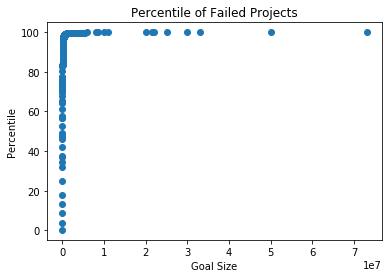

In [43]:
# dictionary for failed projects

df2_fail = df1_fail.copy()
new_dict_fail = {}

for j in df2_fail['goal']:
    curr_key = int(round(j / 1000.0) * 1000.0)
    if curr_key in new_dict_fail.keys():
        new_dict_fail[curr_key] += 1
    else:
        new_dict_fail[curr_key] = 1
        
lst_fail = []
for k,v in new_dict_fail.items():
    temp_lst = [k]*v
    lst_fail.append(temp_lst)
    
lst = []
for k,v in new_dict_fail.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(collections.OrderedDict(sorted(dict_distr.items())))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('Goal Size')
plt.ylabel('Percentile')
plt.title('Percentile of Failed Projects')
plt.show()

In [44]:
# dictionary for probability of success
new_dict_success_rate = {}

for i in new_dict_success.keys():
    if new_dict[i] > 10: # sufficient number of projects with that duration
        new_dict_success_rate[i] = new_dict_success[i] / new_dict[i]

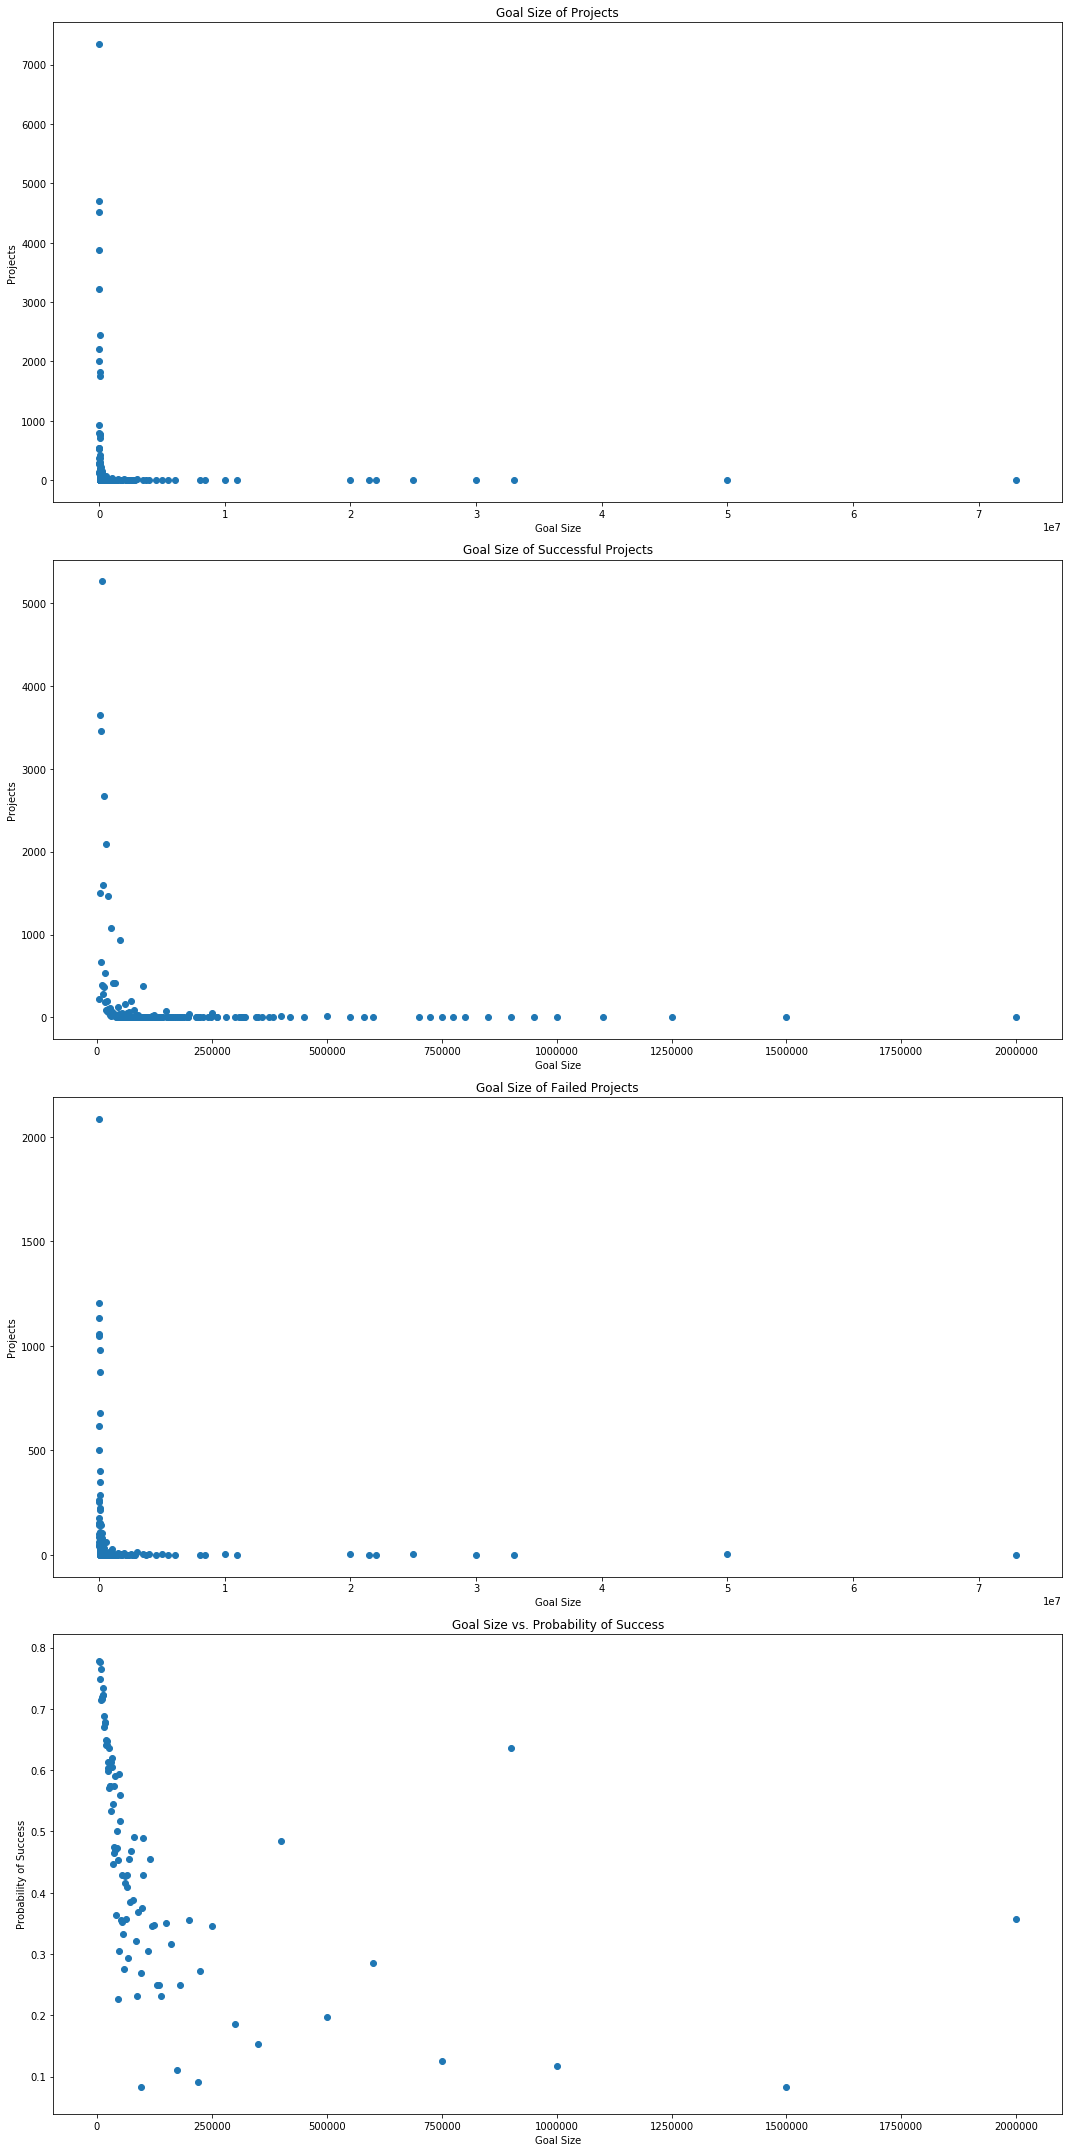

In [45]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

fig = plt.figure(figsize=(15, 30))

# PLOT GOAL SIZE VS NUMBER OF PROEJCTS
plt.subplot(4, 1, 1)
plt.scatter(new_dict.keys(),new_dict.values())
plt.xlabel('Goal Size')
plt.ylabel('Projects')
plt.title('Goal Size of Projects')

# PLOT GOAL SIZE VS NUMBER OF SUCCESSFUL PROEJCTS
plt.subplot(4, 1, 2)
plt.scatter(new_dict_success.keys(),new_dict_success.values())
plt.xlabel('Goal Size')
plt.ylabel('Projects')
plt.title('Goal Size of Successful Projects')

# PLOT GOAL SIZE VS NUMBER OF FAILED PROEJCTS
plt.subplot(4, 1, 3)
plt.scatter(new_dict_fail.keys(),new_dict_fail.values())
plt.xlabel('Goal Size')
plt.ylabel('Projects')
plt.title('Goal Size of Failed Projects')

# PLOT GOAL SIZE VS SUCCESS RATE
plt.subplot(4, 1, 4)
plt.scatter(new_dict_success_rate.keys(),new_dict_success_rate.values())
plt.xlabel('Goal Size')
plt.ylabel('Probability of Success')
plt.title('Goal Size vs. Probability of Success')

plt.tight_layout()

plt.savefig(path3 + 'Monthy_goal_number_success_fail_prob_success.png')

{0: 46464, 500: 46464, 1000: 46464, 5000: 46464, 10000: 34029, 15000: 23024, 20000: 17414, 25000: 13476, 30000: 10501, 40000: 7387, 50000: 6114, 75000: 3255, 100000: 2313, 150000: 1215}
{0: 30586, 500: 30586, 1000: 30586, 5000: 30586, 10000: 21088, 15000: 13183, 20000: 9347, 25000: 6806, 30000: 5030, 40000: 3219, 50000: 2543, 75000: 1193, 100000: 801, 150000: 322}
{0: 0.6582730716253443, 500: 0.6582730716253443, 1000: 0.6582730716253443, 5000: 0.6582730716253443, 10000: 0.6197067207381939, 15000: 0.5725764419735928, 20000: 0.5367520385896405, 25000: 0.5050460077174236, 30000: 0.47900199980954195, 40000: 0.43576553404629753, 50000: 0.41593065096499837, 75000: 0.3665130568356375, 100000: 0.3463035019455253, 150000: 0.2650205761316872}


Text(0.5, 1.0, 'Probability of successful after setting certain goal level')

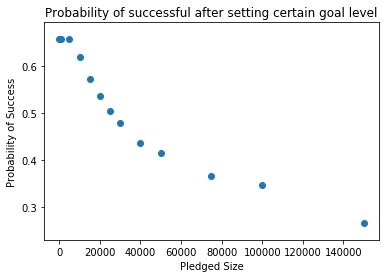

In [47]:
lst = [0, 500, 1000, 5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 75000, 100000, 150000]
dict_all = {}
for i in lst:
    dict_all[i] = 0
for k, v in new_dict.items():
    for j in lst:
        if k >= j:
            dict_all[j] += v
            
dict_success = {}
dict_prob = {}
for i in lst:
    dict_success[i] = 0
    dict_prob[i] = 0
for k, v in new_dict_success.items():
    for j in lst:
        if k >= j:
            dict_success[j] += v
            
for i in lst:
    dict_prob[i] = dict_success[i] / dict_all[i]
      
print(dict_all)
print(dict_success)
print(dict_prob)

plt.scatter(dict_prob.keys(), dict_prob.values())
plt.xlabel('Pledged Size')
plt.ylabel('Probability of Success')
plt.title('Probability of successful after setting certain goal level')

OrderedDict([(100, 1.3978564049586777), (200, 4.6584452479338845), (300, 7.657541322314049), (400, 9.639721074380166), (500, 11.23127582644628), (600, 12.602229683195592), (700, 13.740745523415978), (800, 14.73291150137741), (900, 15.620695592286502), (1000, 16.42239152892562), (1100, 17.176738980716255), (1200, 17.86006370523416), (1300, 18.47989841597796), (1400, 19.111570247933884), (1500, 19.693741391184574), (1600, 20.174758953168045), (1700, 20.647167699724516), (1800, 21.11957644628099), (1900, 21.556473829201103), (2000, 21.9557076446281), (2100, 22.34418044077135), (2200, 22.72081611570248), (2300, 23.066244834710744), (2400, 23.38477100550964), (2500, 23.700068870523417), (2600, 24.006757920110193), (2700, 24.290848829201103), (2800, 24.552341597796143), (2900, 24.795540633608816), (3000, 25.04412017906336), (3100, 25.28947141873278), (3200, 25.514376721763085), (3300, 25.736053719008265), (3400, 25.942665289256198), (3500, 26.140668044077135), (3600, 26.34082300275482), (370

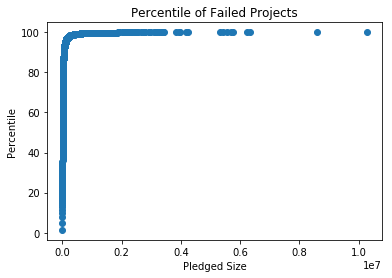

In [25]:
df2 = df1.copy()

max_pledged = round(max(df2['usd_pledged']) / 100.0) * 100.0

# dictionary for all_projects
new_dict = {}

for j in df2['usd_pledged']:
    curr_key = int(round(j / 100.0) * 100.0)
    if curr_key in new_dict.keys():
        new_dict[curr_key] += 1
    else:
        new_dict[curr_key] = 1
        
lst = []
for k,v in new_dict.items():
    temp_lst = [k]*v
    lst.append(temp_lst)
    
lst = []
for k,v in new_dict.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(collections.OrderedDict(sorted(dict_distr.items())))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('Pledged Size')
plt.ylabel('Percentile')
plt.title('Percentile of Failed Projects')
plt.show()

OrderedDict([(5000, 0.003269469692015955), (5200, 0.02615575753612764), (5300, 0.06702412868632708), (5400, 0.11933564375858235), (5500, 0.29261753743542795), (5600, 0.6686065520172628), (5700, 1.1181586346694565), (5800, 1.4728960962531876), (5900, 1.749166285228536), (6000, 2.2755509056431045), (6100, 3.0880141241090695), (6200, 3.853070032040803), (6300, 4.503694500751978), (6400, 5.05950434839469), (6500, 5.590793173347283), (6600, 6.198914536062251), (6700, 6.756359118550971), (6800, 7.217354345125221), (6900, 7.650559079317334), (7000, 8.199829987576015), (7100, 8.950173281893678), (7200, 9.671091348983195), (7300, 10.244883279931996), (7400, 10.785980513960636), (7500, 11.399006081213628), (7600, 12.159157784607336), (7700, 12.873536912312822), (7800, 13.45059831295364), (7900, 13.972078728830184), (8000, 14.612894788465312), (8100, 15.490747400771594), (8200, 16.34407899038776), (8300, 17.06172758778526), (8400, 17.673118420192246), (8500, 18.263257699601123), (8600, 18.8877264

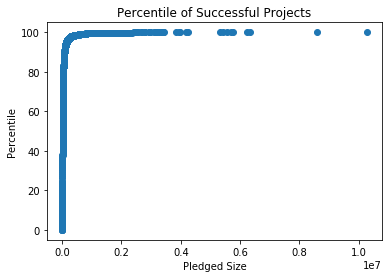

In [26]:
# dictionary for successful projects

df2_success = df1_success.copy()
new_dict_success = {}

for j in df2_success['usd_pledged']:
    curr_key = int(round(j / 100.0) * 100.0)
    if curr_key in new_dict_success.keys():
        new_dict_success[curr_key] += 1
    else:
        new_dict_success[curr_key] = 1
        
lst_success = []
for k,v in new_dict_success.items():
    temp_lst = [k]*v
    lst_success.append(temp_lst)
    
lst = []
for k,v in new_dict_success.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict_success.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(collections.OrderedDict(sorted(dict_distr.items())))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('Pledged Size')
plt.ylabel('Percentile')
plt.title('Percentile of Successful Projects')
plt.show()

OrderedDict([(100, 4.090565562413402), (200, 13.632069530167527), (300, 22.408363773775033), (400, 28.208842423479027), (500, 32.86623000377881), (600, 36.87807028593022), (700, 40.209724146617965), (800, 43.113112482680435), (900, 45.71104673132636), (1000, 48.0570600831339), (1100, 50.26451694168031), (1200, 52.264139060335054), (1300, 54.07796951757148), (1400, 55.92643909812319), (1500, 57.63005416299282), (1600, 59.03766217407734), (1700, 60.42007809547802), (1800, 61.8024940168787), (1900, 63.08099256833354), (2000, 64.24927572742159), (2100, 65.38606877440483), (2200, 66.4882226980728), (2300, 67.49905529663685), (2400, 68.43116261493891), (2500, 69.35382289960953), (2600, 70.2512910945963), (2700, 71.08263005416299), (2800, 71.8478397783096), (2900, 72.55951631187807), (3000, 73.28693790149893), (3100, 74.00491245748835), (3200, 74.66305580047865), (3300, 75.31175210983751), (3400, 75.91636226224965), (3500, 76.49578032497796), (3600, 77.08149641012722), (3700, 77.6546164504345

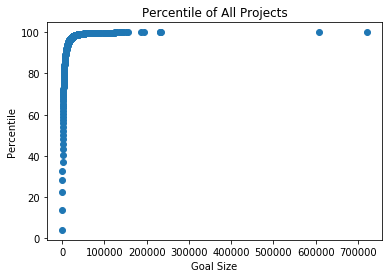

In [27]:
# dictionary for failed projects

df2_fail = df1_fail.copy()
new_dict_fail = {}

for j in df2_fail['usd_pledged']:
    curr_key = int(round(j / 100.0) * 100.0)
    if curr_key in new_dict_fail.keys():
        new_dict_fail[curr_key] += 1
    else:
        new_dict_fail[curr_key] = 1
        
lst_fail = []
for k,v in new_dict_fail.items():
    temp_lst = [k]*v
    lst_fail.append(temp_lst)
    
lst = []
for k,v in new_dict_fail.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict_fail.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(collections.OrderedDict(sorted(dict_distr.items())))
    
plt.scatter(dict_distr.keys(), dict_distr.values())
plt.xlabel('Goal Size')
plt.ylabel('Percentile')
plt.title('Percentile of All Projects')
plt.show()

In [28]:
# dictionary for probability of success
new_dict_success_rate = {}

for i in new_dict_success.keys():
    if new_dict[i] > 10: # sufficient number of projects with that duration
        new_dict_success_rate[i] = new_dict_success[i] / new_dict[i]

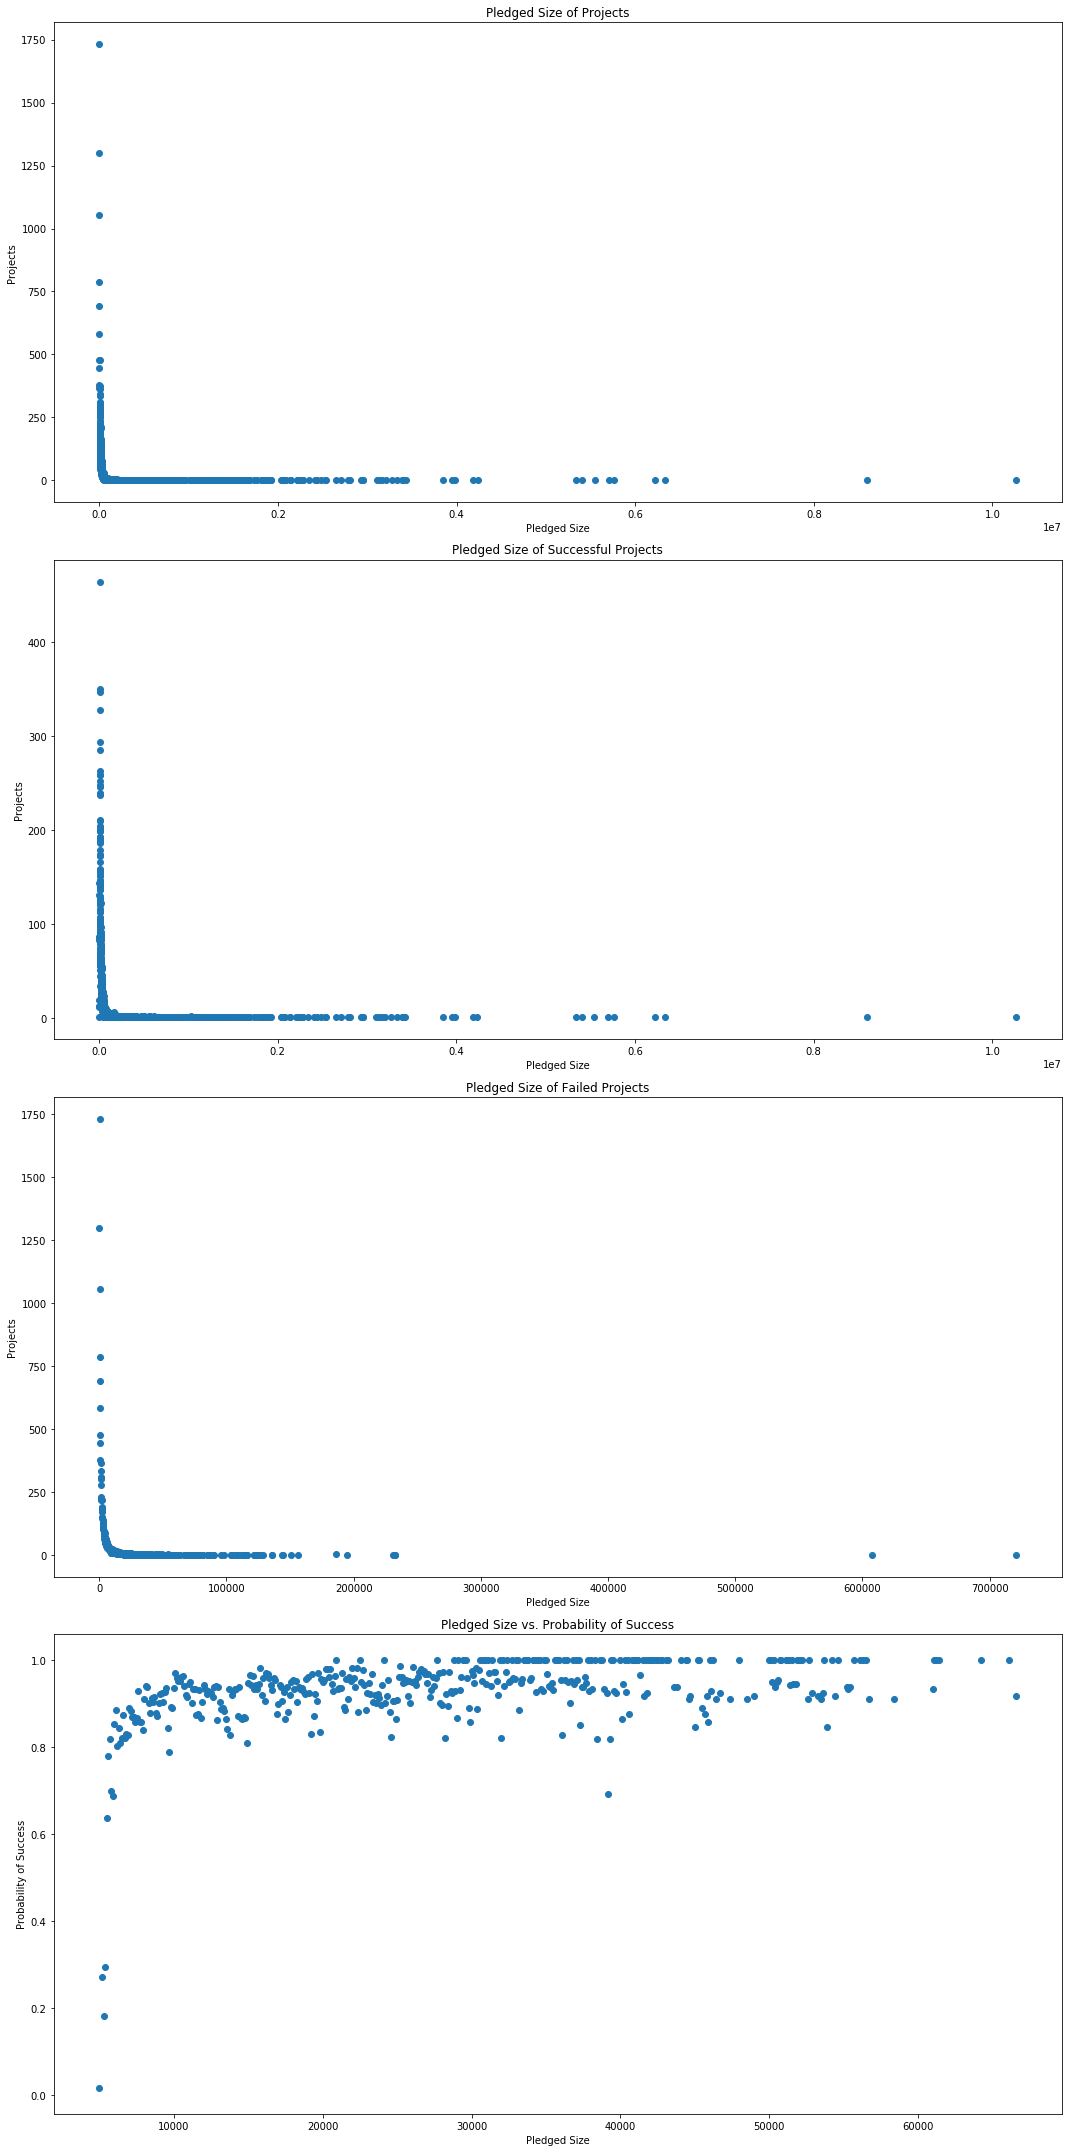

In [29]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

fig = plt.figure(figsize=(15, 30))

# PLOT PLEDGED SIZE VS NUMBER OF PROEJCTS
plt.subplot(4, 1, 1)
plt.scatter(new_dict.keys(),new_dict.values())
plt.xlabel('Pledged Size')
plt.ylabel('Projects')
plt.title('Pledged Size of Projects')

# PLOT PLEDGED SIZE VS NUMBER OF SUCCESSFUL PROEJCTS
plt.subplot(4, 1, 2)
plt.scatter(new_dict_success.keys(),new_dict_success.values())
plt.xlabel('Pledged Size')
plt.ylabel('Projects')
plt.title('Pledged Size of Successful Projects')

# PLOT PLEDGED SIZE VS NUMBER OF FAILED PROEJCTS
plt.subplot(4, 1, 3)
plt.scatter(new_dict_fail.keys(),new_dict_fail.values())
plt.xlabel('Pledged Size')
plt.ylabel('Projects')
plt.title('Pledged Size of Failed Projects')

# PLOT PLEDGED SIZE VS SUCCESS RATE
plt.subplot(4, 1, 4)
plt.scatter(new_dict_success_rate.keys(),new_dict_success_rate.values())
plt.xlabel('Pledged Size')
plt.ylabel('Probability of Success')
plt.title('Pledged Size vs. Probability of Success')

plt.tight_layout()

plt.savefig(path3 + 'Monthy_pledged_number_success_fail_prob_success.png')

{0: 46464, 500: 41592, 1000: 39017, 5000: 33294, 10000: 24515, 15000: 17028, 20000: 12978, 25000: 10358, 30000: 8453, 40000: 6144, 50000: 5020, 75000: 3223, 100000: 2443, 150000: 1489}
{0: 30586, 500: 30586, 1000: 30586, 5000: 30586, 10000: 23211, 15000: 16277, 20000: 12485, 25000: 10017, 30000: 8212, 40000: 5997, 50000: 4916, 75000: 3172, 100000: 2408, 150000: 1479}
{0: 0.6582730716253443, 500: 0.735381804193114, 1000: 0.783914703847041, 5000: 0.9186640235477864, 10000: 0.9468080766877423, 15000: 0.9558961710124501, 20000: 0.9620126367699183, 25000: 0.9670785865997297, 30000: 0.9714894120430616, 40000: 0.97607421875, 50000: 0.9792828685258964, 75000: 0.984176233322991, 100000: 0.9856733524355301, 150000: 0.9932840832773674}


Text(0.5, 1.0, 'Probability of successful after reaching certain pledge level')

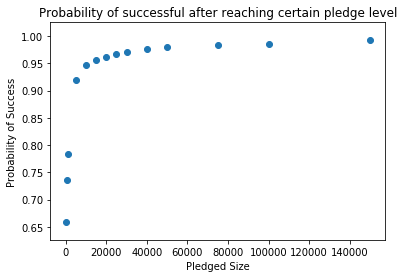

In [40]:
lst = [0, 500, 1000, 5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 75000, 100000, 150000]
dict_all = {}
for i in lst:
    dict_all[i] = 0
for k, v in new_dict.items():
    for j in lst:
        if k >= j:
            dict_all[j] += v
            
dict_success = {}
dict_prob = {}
for i in lst:
    dict_success[i] = 0
    dict_prob[i] = 0
for k, v in new_dict_success.items():
    for j in lst:
        if k >= j:
            dict_success[j] += v
            
for i in lst:
    dict_prob[i] = dict_success[i] / dict_all[i]
      
print(dict_all)
print(dict_success)
print(dict_prob)

plt.scatter(dict_prob.keys(), dict_prob.values())
plt.xlabel('Pledged Size')
plt.ylabel('Probability of Success')
plt.title('Probability of successful after reaching certain pledge level')